In [2]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import os
import numpy as np
import matplotlib.pyplot as plt

import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
tf.config.run_functions_eagerly(True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-2/15-Scene.zip" -d "/content"

Archive:  /content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-2/15-Scene.zip
   creating: /content/15-Scene/00/
  inflating: /content/15-Scene/00/1.jpg  
  inflating: /content/15-Scene/00/10.jpg  
 extracting: /content/15-Scene/00/100.jpg  
 extracting: /content/15-Scene/00/101.jpg  
 extracting: /content/15-Scene/00/102.jpg  
 extracting: /content/15-Scene/00/103.jpg  
 extracting: /content/15-Scene/00/104.jpg  
 extracting: /content/15-Scene/00/105.jpg  
 extracting: /content/15-Scene/00/106.jpg  
 extracting: /content/15-Scene/00/107.jpg  
 extracting: /content/15-Scene/00/108.jpg  
 extracting: /content/15-Scene/00/109.jpg  
  inflating: /content/15-Scene/00/11.jpg  
 extracting: /content/15-Scene/00/110.jpg  
 extracting: /content/15-Scene/00/111.jpg  
 extracting: /content/15-Scene/00/112.jpg  
 extracting: /content/15-Scene/00/113.jpg  
 extracting: /content/15-Scene/00/114.jpg  
 extracting: /content/15-Scene/00/115.jpg  
 e

In [6]:
# testing dataflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_folder = '/content/15-Scene/'
#train_dir = base_folder + 'train'
#val_dir = base_folder + 'val/val_images'

image_size = 64
batch_size = 128
val_batchSize = 128

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    base_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    base_folder, # same directory as training data
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 3592 images belonging to 15 classes.
Found 893 images belonging to 15 classes.


In [18]:
images = train_generator.next()
images[0].shape

(128, 64, 64, 3)

In [ ]:
def read_images(folder):
    imgs = np.zeros((0,64,64,3))
    for filename in os.listdir(folder):
        img = plt.imread(os.path.join(folder,filename))
        img = resize(img, (64,64,3), preserve_range=True)
        if img is not None:
            imgs = np.concatenate([imgs, np.expand_dims(img, 0)], 0)
            
    print(folder, imgs.shape)
            
    return imgs

def read_folder(directory_name='15-Scene'):
    images = np.zeros((0,64,64,3))
    labels = np.zeros((0))

    for path, dirs, files in os.walk(directory_name):
        print(path)
        for i, d in enumerate(dirs):
            imgs = read_images(directory_name + '/' + d)
            images = np.concatenate([images, imgs], 0)
            labels = np.concatenate([labels, i*np.ones((imgs.shape[0]))])

    print(images.shape, labels.shape)
    return images, labels
            
images, labels = read_folder(directory_name = '/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-2/15-Scene')    

/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-2/15-Scene


KeyboardInterrupt: ignored

(4485, 64, 64, 3) (4485,)


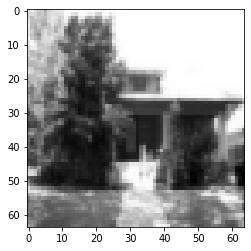

In [ ]:
plt.imshow(images[260,:,:,0], "gray")

print(images.shape, labels.shape)

Normalize dataset

In [ ]:
images.shape, labels.shape

((4485, 64, 64, 3), (4485,))

In [ ]:
num_classes = 15

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=1, stratify=labels)
y_train, y_test = tf.one_hot(y_train, depth=num_classes), tf.one_hot(y_test, depth=num_classes)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3139, 64, 64, 3),
 (1346, 64, 64, 3),
 TensorShape([3139, 15]),
 TensorShape([1346, 15]))

In [ ]:
X_train /= 255.
X_test /= 255.

In [13]:
initializer = 'he_uniform'
num_classes = 15
#initializer = tf.keras.initializers.GlorotUniform()

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer=initializer, padding='same',
                 input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer=initializer, padding='same', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128, activation='elu', kernel_initializer=initializer))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)       

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
28/28 [==============================] - 10s 340ms/step - loss: 2.3782 - accuracy: 0.2790 - val_loss: 5.2368 - val_accuracy: 0.1366
Epoch 2/100
28/28 [==============================] - 9s 335ms/step - loss: 1.9402 - accuracy: 0.3845 - val_loss: 4.7682 - val_accuracy: 0.1221
Epoch 3/100
28/28 [==============================] - 9s 336ms/step - loss: 1.7537 - accuracy: 0.4404 - val_loss: 4.0145 - val_accuracy: 0.2273
Epoch 4/100
28/28 [==============================] - 9s 334ms/step - loss: 1.6041 - accuracy: 0.4833 - val_loss: 4.1980 - val_accuracy: 0.2172
Epoch 5/100
28/28 [==============================] - 9s 334ms/step - loss: 1.5013 - accuracy: 0.5128 - val_loss: 4.4376 - val_accuracy: 0.1814
Epoch 6/100
28/28 [==============================] - 9s 329ms/step - loss: 1.4382 - accuracy: 0.5303 - val_loss: 2.8098 - val_accuracy: 0.3281
Epoch 7/100
28/28 [==============================] - 9s 329ms/step - loss: 1.3526 - accuracy: 0.5482 - val_loss: 4.7908 - val_accuracy: 0.238

In [16]:
model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignmet-2/cifer10_model_.h5')

In [ ]:
datagen = True
batch_size = 256
epochs = 100

if datagen == False:
  print('Not using data augmentation.')
  history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)

else:
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      zca_epsilon=1e-06,  # epsilon for ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0.,  # set range for random shear
      zoom_range=0.,  # set range for random zoom
      channel_shift_range=0.,  # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0.,  # value used for fill_mode = "constant"
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False,  # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)

  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(X_train)

  # Fit the model on the batches generated by datagen.flow().
  history = model.fit_generator(datagen.flow(X_train, y_train,
                                  batch_size=batch_size),
                      epochs=epochs,
                      validation_data=(X_test, y_test))
# Save model and weights

save_dir = '/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-2/models'
model_name = 'He_initializer_wo_aug'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Not using data augmentation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
13/13 [==============================] - 39s 436ms/step - loss: 2.5053 - accuracy: 0.2686 - val_loss: 8.5484 - val_accuracy: 0.1196
Epoch 2/100
13/13 [==============================] - 4s 345ms/step - loss: 1.6525 - accuracy: 0.4568 - val_loss: 5.9333 - val_accuracy: 0.1597
Epoch 3/100
13/13 [==============================] - 4s 347ms/step - loss: 1.2889 - accuracy: 0.5776 - val_loss: 5.1672 - val_accuracy: 0.2080
Epoch 4/100
13/13 [==============================] - 4s 338ms/step - loss: 1.0946 - accuracy: 0.6426 - val_loss: 6.3053 - val_accuracy: 0.1516
Epoch 5/100
13/13 [==============================] - 4s 338ms/step - loss: 0.9494 - accuracy: 0.6849 - val_loss: 4.7466 - val_accuracy: 0.1790
Epoch 6/100
13/13 [==============================] - 4s 346ms/step - loss: 0.8539 - accuracy: 0.7200 - val_loss: 4.7067 - val_accuracy: 0.1798
Epoch 7/100
13/13 [==============================] - 4s 338ms/step - loss: 0.7151 - accuracy: 0.7729 - val_loss: 3.8980 - val_accuracy: 0.235

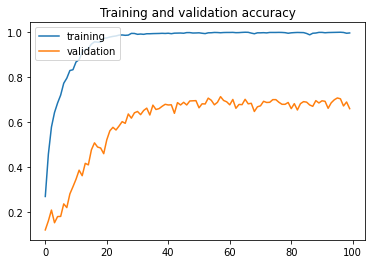

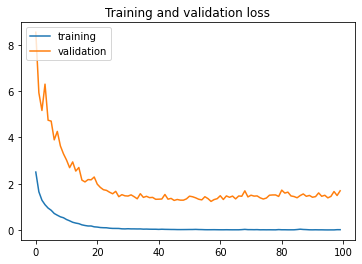

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show() 

NameError: ignored